# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

Построим модель градиентного бустинга. А также более простые модели, которые порой могут работать лучше. Эти редкие случаи, но важно их не пропустить.
Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.

## Подготовка данных

In [28]:
!pip install fast_ml;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
pip install catboost;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import pandas as pd  # импорт библиотек
import numpy as np
import seaborn as sns
from math import sqrt

from fast_ml.model_development import train_valid_test_split  # для разбиения на 3 выборки

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [31]:
from google.colab import drive   # подключение гугл-диска
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:
data = pd.read_csv('/content/drive/MyDrive/_PYTHON/YandexPracticum/Car_cost/autos.csv') # загрузка данных

In [33]:
data.head()  # первые пять строк дата-сета

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Перевести названия столбцов в "змеиный регистр", даты в соответствующий тип

In [34]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [35]:
data.rename(columns={'DateCrawled':'date_crawled', 'Price':'price', 'VehicleType':'vehicle_type',
                     'RegistrationYear':'registration_year', 'Gearbox':'gearbox', 'Power':'power',
                     'Model':'model', 'Kilometer':'kilometer', 'RegistrationMonth':'registration_month',
                     'FuelType':'fuel_type', 'Brand':'brand', 'Repaired':'repaired', 'DateCreated':'date_created', 
                     'NumberOfPictures':'number_of_pictures', 'PostalCode':'postal_code', 'LastSeen':'last_seen'},
           inplace=True)  # перевели названия столбцов в привычный "змеиный регистр" и посморели общую информацию о данных     

In [36]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [37]:
data.repaired.unique() # Ремонт - заменить "yes" на "1", "no" на "0"

array([nan, 'yes', 'no'], dtype=object)

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

In [38]:
data = data.replace({'repaired': {'yes': 1, 'no': 0}}) # заменили

In [39]:
data.gearbox.unique() # Коробка передач - заменить "manual" на "1", "auto" на "0"

array(['manual', 'auto', nan], dtype=object)

In [40]:
data = data.replace({'gearbox': {'manual': 1, 'auto': 0}}) # заменили

In [41]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format="%Y/%m/%d %H:%M:%S") # смена типа object на datetime      

In [42]:
data['date_created'] = pd.to_datetime(data['date_created'], format="%Y/%m/%d %H:%M:%S")

In [43]:
data['last_seen'] = pd.to_datetime(data['last_seen'], format="%Y/%m/%d %H:%M:%S")

In [44]:
data.describe()

,price,registration_year,gearbox,power,kilometer,registration_month,repaired,number_of_pictures,postal_code
count,354369.000000,354369.000000,334536.000000,354369.000000,354369.000000,354369.000000,283215.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,0.801860,110.094337,128211.172535,5.714645,0.127303,0.0,50508.689087
std,4514.158514,90.227958,0.398599,189.850405,37905.341530,3.726421,0.333312,0.0,25783.096248
min,0.000000,1000.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,1.000000,69.000000,125000.000000,3.000000,0.000000,0.0,30165.000000
50%,2700.000000,2003.000000,1.000000,105.000000,150000.000000,6.000000,0.000000,0.0,49413.000000
75%,6400.000000,2008.000000,1.000000,143.000000,150000.000000,9.000000,0.000000,0.0,71083.000000
max,20000.000000,9999.000000,1.000000,20000.000000,150000.000000,12.000000,1.000000,0.0,99998.000000


Почти в каждом столбце есть аномальные значения. Например год регистрации 1000 или 9999. Мощность 0. Месяц регистрации 0. Цена 0. Мощность 20000 тоже выглядит странно. Так же как и цена 20000. Совсем нет картинок, тогда этот столбец лишний. 

In [45]:
data = data.drop('number_of_pictures', axis=1) # удалим этот столбец, как неинформативный (константная колонка)

In [46]:
data.loc[(data['power'] > 3500)] # аномальные значения мощности (больше мощности Белаза)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,1.0,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,0,sedan,1998,1.0,10317,other,150000,8,petrol,fiat,0.0,2016-03-25,57520,2016-04-01 19:16:33
25232,2016-03-28 19:57:39,10900,bus,2009,1.0,10520,caddy,150000,6,gasoline,volkswagen,0.0,2016-03-28,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,1.0,6920,aygo,90000,10,NaN,toyota,0.0,2016-03-09,94116,2016-03-17 05:16:32
44520,2016-03-10 22:37:21,2500,convertible,1998,1.0,7512,golf,150000,6,NaN,volkswagen,NaN,2016-03-10,68239,2016-04-05 15:17:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339642,2016-03-07 16:58:44,600,sedan,2000,1.0,10110,focus,125000,12,petrol,ford,NaN,2016-03-07,35066,2016-03-07 17:41:33
341066,2016-04-03 22:57:04,449,NaN,2016,1.0,4507,corsa,150000,4,petrol,opel,0.0,2016-04-03,29525,2016-04-06 00:16:11
341320,2016-03-29 21:40:33,1899,other,2006,1.0,7518,berlingo,125000,11,petrol,citroen,1.0,2016-03-29,89428,2016-03-31 15:17:03
346639,2016-03-25 12:55:36,1300,sedan,2000,1.0,12512,carisma,150000,9,petrol,mitsubishi,NaN,2016-03-25,42105,2016-04-06 14:44:53


In [47]:
data.drop(data.loc[(data['power'] > 3500)].index, inplace=True) # удалим, так как их очень мало - всего 88 строчек

In [48]:
data.loc[(data['registration_year'] < 1900) | (data['registration_year'] > 2016)] # аномальные значения года регистрации (Год выгрузки БД – 2016, так что нужно ограничить сверху именно этим числом)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,1.0,90,meriva,150000,5,petrol,opel,0.0,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,1.0,125,c4,125000,4,NaN,citroen,0.0,2016-03-10,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,1.0,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,1.0,90,punto,150000,11,gasoline,fiat,1.0,2016-03-07,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,1.0,64,other,125000,3,NaN,seat,0.0,2016-03-10,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,1.0,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,1.0,101,a4,150000,9,NaN,audi,NaN,2016-03-29,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,1.0,80,fiesta,150000,6,NaN,ford,0.0,2016-03-17,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,45527,2016-04-06 07:46:13


In [49]:
data.drop(data.loc[(data['registration_year'] < 1900) | (data['registration_year'] > 2016)].index, inplace=True) 
# удалим, так как их очень мало - всего 171 строчка

In [50]:
data.loc[(data['registration_month'] == 0 )] # аномальные значения месяца регистрации


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,1.0,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,1.0,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,1.0,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,2943,2016-04-07 03:46:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,74579,2016-04-05 12:44:38
354318,2016-03-15 19:57:11,400,wagon,1991,1.0,0,legacy,150000,0,petrol,subaru,NaN,2016-03-15,24558,2016-03-19 15:49:00
354326,2016-03-31 19:36:18,1300,small,1999,1.0,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31,35102,2016-04-06 13:44:44
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,25436,2016-04-07 13:50:41


Таких значений много, порядка 10 %, удалять нельзя. Просто не проставлен месяц при заполнении, возник ноль. Но этот признак не влияет на цену. Поэтому можно не заполнять пропуски. А какие признаки влияют? Посмотрим корреляцию.

In [51]:
data.corr() # корреляция признаков

,price,registration_year,gearbox,power,kilometer,registration_month,repaired,postal_code
price,1.000000,0.430442,-0.251812,0.411908,-0.336983,0.107328,-0.243569,0.075775
registration_year,0.430442,1.000000,-0.042599,0.133533,-0.197711,0.077455,-0.120226,0.034580
gearbox,-0.251812,-0.042599,1.000000,-0.308484,-0.015568,-0.034874,0.028455,0.034091
power,0.411908,0.133533,-0.308484,1.000000,0.075208,0.108678,-0.084612,0.060033
kilometer,-0.336983,-0.197711,-0.015568,0.075208,1.000000,0.009265,0.088597,-0.008059
registration_month,0.107328,0.077455,-0.034874,0.108678,0.009265,1.000000,-0.075857,0.013127
repaired,-0.243569,-0.120226,0.028455,-0.084612,0.088597,-0.075857,1.000000,-0.009740
postal_code,0.075775,0.034580,0.034091,0.060033,-0.008059,0.013127,-0.009740,1.000000


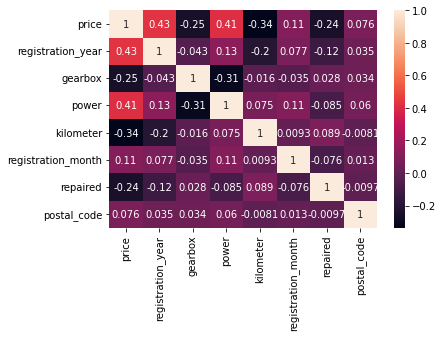

In [52]:
sns.heatmap(data.corr(), annot = True); # тепловая карта матрицы корреляций

Целевой признак - цена. Самая большая отрицательная корреляция с пробегом, то есть чем пробег больше, тем цена меньше. И с ремонтом: есть ремонт - цена ниже. Коробка автомат - цена выше. Немного зависит от мощности и, почему то, от месяца регистрации, а от года почти не зависит. И от почтового кода почти не зависит, но это логично.

In [53]:
data = data.drop('postal_code', axis=1) # удалим этот столбец, как неинформативный

In [54]:
data = data.drop('registration_month', axis=1) # удалим этот столбец, как малоинформативный

In [55]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'date_created', 'last_seen'],
      dtype='object')

In [56]:
data.shape # размер датасета немного уменьшился

(339692, 13)

In [57]:
data.isna().sum() # кол-во пропущенных значений по столбцам

date_crawled             0
price                    0
vehicle_type         22908
registration_year        0
gearbox              17906
power                    0
model                17617
kilometer                0
fuel_type            27235
brand                    0
repaired             64770
date_created             0
last_seen                0
dtype: int64

In [59]:
data.repaired.isna().sum() / data.shape[0] # доля пропущенных значений

0.1906727270586296

Есть пять столбцов с существенным (более 20%) кол-вом пропущенных значений. Чем заполнить пропуски?

In [60]:
data.vehicle_type.unique() # можно вместо 'nan' сделать 'other'

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [61]:
data.vehicle_type.fillna('other', inplace=True) # убрали пропуски
data.vehicle_type.isna().sum()

0

In [62]:
data.repaired.unique() # где нет данных о ремонте заполним "2"

array([nan,  1.,  0.])

In [63]:
data.repaired.fillna(2, inplace=True) # убрали пропуски
data.repaired.isna().sum()

0

In [64]:
data.fuel_type.unique() # можно вместо 'nan' сделать 'other'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [65]:
data.fuel_type.fillna('other', inplace=True) # убрали пропуски
data.fuel_type.isna().sum()

0

In [66]:
data.gearbox.unique() # где нет данных о коробке передач заполним "2"

array([ 1.,  0., nan])

In [67]:
data.gearbox.fillna(2, inplace=True) # убрали пропуски
data.gearbox.isna().sum()

0

In [68]:
data.model.unique() # где нет данных о модели авто заполним "unknown"

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',


In [69]:
data.model.fillna('unknown', inplace=True) # зполнили пропуски значением "unknown"
data.model.isna().sum()

0

In [70]:
data[['gearbox', 'repaired']] = data[['gearbox', 'repaired']].astype(int) # сменим тип данных

In [71]:
data.isna().sum() # кол-во пропущенных значений по столбцам

date_crawled         0
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
date_created         0
last_seen            0
dtype: int64

In [72]:
data.brand.unique() # 

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'land_rover', 'lada'], dtype=object)

Для обучения модели столбцы с датами `date_crawled`, `date_created` и `last_seen` не несут никакой смысловой нагрузки. Удалим их из датасета

In [73]:
data = data.drop('date_crawled', axis=1) # удалим этот столбцы, как неинформативные
data = data.drop('date_created', axis=1) 
data = data.drop('last_seen', axis=1) 

In [75]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,1,0,golf,150000,petrol,volkswagen,2
1,18300,coupe,2011,1,190,unknown,125000,gasoline,audi,1
2,9800,suv,2004,0,163,grand,125000,gasoline,jeep,2
3,1500,small,2001,1,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,1,69,fabia,90000,gasoline,skoda,0


## Обучение моделей

### Градиентный бустинг CatBoostRegressor

In [76]:
enc_cols = ['vehicle_type', 'model', 'fuel_type', 'brand', 'gearbox', 'repaired'] # 6 категорий
num_cols = ['registration_year', 'power', 'kilometer', ]                          # 3 цифровых признака
features, target = data[enc_cols + num_cols], data['price']

In [77]:
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
    data, target = 'price', train_size=0.6, valid_size=0.2, test_size=0.2, random_state=12345) # на три выборки

In [78]:
features_train.shape, features_test.shape, features_valid.shape

((203815, 9), (67939, 9), (67938, 9))

In [79]:
cbr_model = CatBoostRegressor(silent=True, iterations=100)

In [80]:
cat_features = enc_cols     # 6 категориальных признаков

In [81]:
%%time
cbr_model.fit(features_train, target_train, cat_features=cat_features, verbose=10)  # обучение модели CatBoostRegressor

Learning rate set to 0.5
0:	learn: 3258.0815067	total: 157ms	remaining: 15.6s
10:	learn: 2020.7251485	total: 966ms	remaining: 7.81s
20:	learn: 1925.5302828	total: 1.74s	remaining: 6.56s
30:	learn: 1882.8914774	total: 2.5s	remaining: 5.58s
40:	learn: 1839.6700376	total: 3.3s	remaining: 4.75s
50:	learn: 1814.1791223	total: 4.09s	remaining: 3.93s
60:	learn: 1794.1299786	total: 4.84s	remaining: 3.1s
70:	learn: 1779.8570532	total: 5.61s	remaining: 2.29s
80:	learn: 1768.7371273	total: 6.96s	remaining: 1.63s
90:	learn: 1757.0383948	total: 8.42s	remaining: 833ms
99:	learn: 1749.1307240	total: 9.71s	remaining: 0us
CPU times: user 14.9 s, sys: 306 ms, total: 15.2 s
Wall time: 10.2 s


In [82]:
cbr_fit_time = 10.2 # время обучения модели, секунды

In [83]:
%%time
pred_valid = cbr_model.predict(features_valid) # предсказание модели на валидационной выборке

CPU times: user 148 ms, sys: 757 µs, total: 149 ms
Wall time: 121 ms


In [84]:
cbr_predict_time = 0.12 # время предсказания модели, секунды

In [85]:
cbr_r2 = r2_score(target_valid, pred_valid) # метрика R2
print('Метрика R2:', cbr_r2)

Метрика R2: 0.8455705322878453


In [86]:
cbr_rmse = sqrt(mean_squared_error(target_valid, pred_valid)) # RMSE - кв.корень из MSE - средней квадратичной ошибки
print('Метрика RMSE:', cbr_rmse)

Метрика RMSE: 1787.8260944613876


### RandomForestRegressor

Чтобы использовать моделм случайного леса и линейной регрессии нужно категориальные признаки перевести в цифровые

In [87]:
ct = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), enc_cols), 
    (StandardScaler(), num_cols), 
    remainder='passthrough'
)
model_log_pipe = Pipeline(steps=[('prep', ct), ('reg', RandomForestRegressor())])

rfr_model = GridSearchCV(model_log_pipe, {'reg__max_depth':[3], 'reg__n_estimators':[50]}, scoring='neg_mean_squared_error')

In [88]:
%%time
rfr_model.fit(features_train, target_train);  # обучение модели RandomForestRegressor

CPU times: user 29.7 s, sys: 0 ns, total: 29.7 s
Wall time: 30.2 s


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['vehicle_type',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'gearbox',
                                                                          'repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer'])])),
                                       ('reg', RandomForestRegressor())]),
             param_grid={'reg__max_depth': [3], 'reg__n_estimators': [50]},
             scoring='neg_mean_squared_error')

In [90]:
rfr_fit_time = 30.2 # время обучения модели, секунды

In [91]:
pd.DataFrame(rfr_model.cv_results_).iloc[rfr_model.best_index_]['mean_fit_time'], \
pd.DataFrame(rfr_model.cv_results_).iloc[rfr_model.best_index_]['mean_score_time'],\
(rfr_model.best_score_*(-1))**0.5

(4.679326677322388, 0.13328490257263184, 2909.6886998167092)

In [92]:
%%time
pred_valid = rfr_model.predict(features_valid)  # предсказание модели на валидационной выборке

CPU times: user 196 ms, sys: 534 µs, total: 196 ms
Wall time: 196 ms


In [93]:
rfr_predict_time = 0.196 # время предсказания модели, секунды

In [94]:
rfr_r2 = r2_score(target_valid, pred_valid) # метрика R2
print('Метрика R2:', rfr_r2)

Метрика R2: 0.593697278600872


In [95]:
rfr_rmse = sqrt(mean_squared_error(target_valid, pred_valid)) # RMSE - кв.корень из MSE - средней квадратичной ошибки
print('Метрика RMSE:',rfr_rmse)

Метрика RMSE: 2899.9135426943517


###  LinearRegression 

In [96]:
ct = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), enc_cols), 
    (StandardScaler(), num_cols), 
    remainder='passthrough'
)

In [97]:
model_log_pipe = Pipeline(steps=[('prep', ct), ('reg', LinearRegression())])

In [98]:
lr_model = GridSearchCV(model_log_pipe, {}, scoring='neg_mean_squared_error')

In [99]:
%%time
lr_model.fit(features_train, target_train)   # обучение модели LinearRegression

CPU times: user 2.39 s, sys: 981 ms, total: 3.37 s
Wall time: 2.41 s


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['vehicle_type',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'gearbox',
                                                                          'repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer'])])),
                                       ('reg', LinearRegression())]),
             param_grid={}, scoring='neg_mean_squared_error')

In [100]:
lr_fit_time = 2.41 # время обучения модели, секунды

In [101]:
%%time
pred_valid = lr_model.predict(features_valid)  # предсказание модели на валидационной выборке

CPU times: user 211 ms, sys: 3.52 ms, total: 215 ms
Wall time: 326 ms


In [102]:
lr_predict_time = 0.326 # время предсказания модели, секунды

In [103]:
lr_r2 = r2_score(target_valid, pred_valid) # метрика R2
print('Метрика R2:', lr_r2)

Метрика R2: 0.4719556432809997


In [104]:
lr_rmse = sqrt(mean_squared_error(target_valid, pred_valid)) # RMSE - кв.корень из MSE - средней квадратичной ошибки
print('Метрика RMSE:', lr_rmse)

Метрика RMSE: 3305.9431979696733


###  LGBMRegressor 

In [117]:
ct = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), enc_cols), 
    (StandardScaler(), num_cols), 
    remainder='passthrough'
)

In [118]:
model_log_pipe = Pipeline(steps=[('prep', ct), ('reg', LGBMRegressor())])

lgbmr_model = GridSearchCV(model_log_pipe, {'reg__max_depth':[3], 'reg__n_estimators':[50]}, scoring='neg_mean_squared_error')

In [119]:
%%time
lgbmr_model.fit(features_train, target_train)  # обучение модели LGBMRegressor

CPU times: user 8.02 s, sys: 10.6 ms, total: 8.03 s
Wall time: 5.09 s


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['vehicle_type',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'gearbox',
                                                                          'repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer'])])),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__max_depth': [3], 'reg__n_estimators': [50]},
             scoring='neg_mean_squared_error')

In [120]:
lgbmr_fit_time = 5.09 # время обучения модели, секунды

In [121]:
%%time
pred_valid = lgbmr_model.predict(features_valid)  # предсказание модели на валидационной выборке

CPU times: user 274 ms, sys: 0 ns, total: 274 ms
Wall time: 184 ms


In [122]:
lgbmr_predict_time = 0.184 # время предсказания модели, секунды

In [123]:
lgbmr_r2 = r2_score(target_valid, pred_valid) # метрика R2
print('Метрика R2:', lgbmr_r2)

Метрика R2: 0.7773076022756331


In [124]:
lgbmr_rmse = sqrt(mean_squared_error(target_valid, pred_valid)) # RMSE - кв.корень из MSE - средней квадратичной ошибки
print('Метрика RMSE:', lgbmr_rmse)

Метрика RMSE: 2146.90526081341


## Анализ моделей

In [125]:
models = ['CatBoostRegressor', 'RandomForestRegressor', 'LinearRegression ', 'LGBMRegressor ']
fit_time = [cbr_fit_time, rfr_fit_time, lr_fit_time, lgbmr_fit_time]
predict_time = [cbr_predict_time, rfr_predict_time, lr_predict_time, lgbmr_predict_time]
r2 = [cbr_r2, rfr_r2, lr_r2, lgbmr_r2]
rmse = [cbr_rmse, rfr_rmse, lr_rmse, lgbmr_rmse]

In [126]:
model_data = {'models': models, 'fit_time': fit_time, 'predict_time': predict_time, 'r2': r2, 'rmse': rmse }

In [127]:
df = pd.DataFrame(model_data)

In [128]:
df

,models,fit_time,predict_time,r2,rmse
0,CatBoostRegressor,10.20,0.120,0.845571,1787.826094
1,RandomForestRegressor,30.20,0.196,0.593697,2899.913543
2,LinearRegression,2.41,0.326,0.471956,3305.943198
3,LGBMRegressor,5.09,0.184,0.777308,2146.905261


<b>Выводы:</b> 
* По метрике RMSE лучший результат показала модель `CatBoostRegressor`. На втором месте `LGBMRegressor`. Простые модели линейной регресии и случайного леса в этот раз не прошли проверку качеством. RMSE у них выше 2500.<br><br>
* По скорости обучения, из двух оставшихся моделей, прошедших фильтр качества, `LGBMRegressor` в 2 раза быстрее обучилась, чем `CatBoostRegressor`, но предсказывает `LGBMRegressor` в 1,5 раза медленнее, чем `CatBoostRegressor`  <br><br>
* Итого, по совокупности параметров и учёте того, что главным параметром является точность предсказания, победила модель `CatBoostRegressor`. Ура, ура!

Проверим лучшую модель на тестовой выборке:

In [129]:
%%time
pred_test = cbr_model.predict(features_test) # тестовая выборка

CPU times: user 137 ms, sys: 2.94 ms, total: 140 ms
Wall time: 110 ms


In [130]:
cbr_predict_time = 0.081 # время предсказания модели, секунды

In [131]:
cbr_r2 = r2_score(target_test, pred_test) # метрика R2
print('Метрика R2:', cbr_r2)

Метрика R2: 0.8458272552881092


In [132]:
cbr_rmse = sqrt(mean_squared_error(target_test, pred_test)) # RMSE - кв.корень из MSE - средней квадратичной ошибки
print('Метрика RMSE:', cbr_rmse)

Метрика RMSE: 1793.257368584131


На тестовой выборке метрики не ухудшились